<a href="https://colab.research.google.com/github/nprime496/building-floor-recognition/blob/main/code/data_cleaning_audio_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

sortie de u-net avec plusieurs channels

# BUILDING FLOOR RECOGNITION

Inspired by https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/audio_classifier_tutorial.ipynb

# Table of Contents

>[BUILDING FLOOR RECOGNITION](#scrollTo=SsIKuyArEu5c)

>[Table of Contents](#scrollTo=4sAfyFF7dWGm)

>[setup](#scrollTo=nogA7rji8GbZ)

>[utils](#scrollTo=1o3-BVUy8-sF)

>[Data](#scrollTo=pk-sYaYF7U9Y)

>>[Clean Data source](#scrollTo=uHL0auVWCnL6)

>>[sample audio](#scrollTo=w9GlJyvB2SoK)



In [ ]:
# https://stats.stackexchange.com/questions/559009/why-convert-spectrogram-to-rgb-for-machine-learning

same buildings recording shall not be distributed between train and test sets


Remember:

* Train with more data
* Data Augmentation
* adding noise to the input and ouput data
* feature selection
* cross-validation
* simplify data
* regularization
* ensembling
* early stopping
* adding dropout layers


# setup

In [33]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
from torch.autograd import Variable
from torch import nn

print(torch.__version__)
print(torchaudio.__version__)

1.12.0+cu113
0.12.0+cu113


In [34]:
import random 
import os
from copy import deepcopy
from tqdm import tqdm

In [6]:
import pandas as pd
import seaborn as sns 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [7]:
from IPython.display import Audio, display
from typing import Dict,Any

In [8]:
import librosa


/usr/local/lib/python3.7/dist-packages/resampy/interpn.py:114: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  _resample_loop_p(x, t_out, interp_win, interp_delta, num_table, scale, y)


In [10]:
def seed_all(SEED_VAL=1):
        random.seed(SEED_VAL)
        np.random.seed(SEED_VAL)
        os.environ['PYTHONHASHSEED'] = str(SEED_VAL)

In [11]:
seed_all(496)

In [12]:
!pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
# show current directory
!pwd

/content


# utils

In [ ]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [41]:
def print_stats(waveform, sample_rate=None, src=None):
  if src:
    print("-" * 10)
    print("Source:", src)
    print("-" * 10)
  if sample_rate:
    print("Sample Rate:", sample_rate)
  print("Shape:", tuple(waveform.shape))
  print("Dtype:", waveform.dtype)
  print(f" - Max:     {waveform.max().item():6.3f}")
  print(f" - Min:     {waveform.min().item():6.3f}")
  print(f" - Mean:    {waveform.mean().item():6.3f}")
  print(f" - Std Dev: {waveform.std().item():6.3f}")
  print()
  print(waveform)
  print()


In [42]:
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth=1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)
  figure.suptitle(title)
  plt.show(block=False)


In [43]:
def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.show(block=False)


In [44]:

def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].specgram(waveform[c], Fs=sample_rate)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
  figure.suptitle(title)
  plt.show(block=False)


In [45]:
def play_audio(waveform, sample_rate):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  if num_channels == 1:
    display(Audio(waveform[0], rate=sample_rate))
  elif num_channels == 2:
    display(Audio((waveform[0], waveform[1]), rate=sample_rate))
  else:
    raise ValueError("Waveform with more than 2 channels are not supported.")


# Data 

## Clean Data source

In [1]:
!rm -r Data

rm: cannot remove 'Data': No such file or directory


In [2]:
!wget http://aptikal.imag.fr/~amini/R+3.tar.bz2
!tar xvf R+3.tar.bz2
!rm R+3.tar.bz2

--2022-07-19 13:40:26--  http://aptikal.imag.fr/~amini/R+3.tar.bz2
Resolving aptikal.imag.fr (aptikal.imag.fr)... 129.88.12.12, 2001:660:5301:61::12:12
Connecting to aptikal.imag.fr (aptikal.imag.fr)|129.88.12.12|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16925918 (16M) [application/x-bzip2]
Saving to: ‘R+3.tar.bz2’

R+3.tar.bz2         100%[===================>]  16.14M  11.7MB/s    in 1.4s    

2022-07-19 13:40:28 (11.7 MB/s) - ‘R+3.tar.bz2’ saved [16925918/16925918]

._R+3
R+3/
R+3/._Esquissons_EC07A_1.wav
R+3/Esquissons_EC07A_1.wav
R+3/._Esquissons_EC07A_2.wav
R+3/Esquissons_EC07A_2.wav
R+3/._Esquissons_FV02.wav
R+3/Esquissons_FV02.wav
R+3/._Esquissons_EC11.wav
R+3/Esquissons_EC11.wav
R+3/._Esquissons_CB05S01.wav
R+3/Esquissons_CB05S01.wav
R+3/._Esquissons_VM09.wav
R+3/Esquissons_VM09.wav
R+3/._Esquissons_FV03B.wav
R+3/Esquissons_FV03B.wav
R+3/._Esquissons_VM03_1.wav
R+3/Esquissons_VM03_1.wav
R+3/._Esquissons_EC08B_1.wav
R+3/Esquissons_EC08B_1.wav
R+3/

In [14]:
for root,dirs,file in os.walk("R+3"):
  for f in file:
    if f[0]!='.':
      dirname = f.split(".")[0][11:]
      os.mkdir(f"R+3/{dirname}")
      os.rename(f"R+3/{f}",f"R+3/{dirname}/{f}")

R+3 [] ['Esquissons_EC10_2.wav', '._Esquissons_EC10_2.wav', 'Esquissons_EC07A_2.wav', 'Esquissons_EC08B_2.wav', 'Esquissons_VM03_1.wav', '._Esquissons_EC08B_2.wav', 'Esquissons_FV03B.wav', '._Esquissons_EC07A_1.wav', 'Esquissons_FV02.wav', '._Esquissons_CB05S01.wav', '._Esquissons_VM03_1.wav', '._Esquissons_EC08B_1.wav', 'Esquissons_CB05S01.wav', '._Esquissons_VM09.wav', 'Esquissons_EC11.wav', '._Esquissons_FV03B.wav', 'Esquissons_EC07A_1.wav', 'Esquissons_EC08B_1.wav', '._Esquissons_EC10_1.wav', '._Esquissons_EC07A_2.wav', 'Esquissons_EC10_1.wav', '._Esquissons_FV02.wav', '._Esquissons_EC11.wav', 'Esquissons_VM09.wav']
EC10_2
EC07A_2
EC08B_2
VM03_1
FV03B
FV02
CB05S01
EC11
EC07A_1
EC08B_1
EC10_1
VM09


In [15]:
# Unzip dataset
!wget https://aptikal.imag.fr/~amini/Data.zip 
!unzip -o -qqq Data.zip
!rm Data.zip
!unzip -o -qqq Data/R+1.zip
!rm Data/R+1.zip
!unzip -o -qqq Data/R+5.zip 
!rm  -r Data/R+5.zip
!rm -r Data

--2022-07-19 13:41:52--  https://aptikal.imag.fr/~amini/Data.zip
Resolving aptikal.imag.fr (aptikal.imag.fr)... 129.88.12.12, 2001:660:5301:61::12:12
Connecting to aptikal.imag.fr (aptikal.imag.fr)|129.88.12.12|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 147384293 (141M) [application/zip]
Saving to: ‘Data.zip’

Data.zip            100%[===================>] 140.56M  25.2MB/s    in 6.4s    

2022-07-19 13:41:59 (22.0 MB/s) - ‘Data.zip’ saved [147384293/147384293]



In [35]:
from pydub import AudioSegment 
from pydub.utils import make_chunks
import os

def process_sudio(file_name,chunk_length_ms):
    myaudio = AudioSegment.from_file(file_name, "wav") 
    #chunk_length_ms = 5000 # pydub calculates in millisec 
    chunks = make_chunks(myaudio,chunk_length_ms) #Make chunks of chunk_length_ms/1000 sec 
    # print(len(chunks[5]))
    for i, chunk in enumerate(chunks):
        if len(chunk)==(chunk_length_ms):
          chunk_name = './' + file_name + "_{0}.wav".format(i) 
          #print ("exporting", chunk_name) 
          chunk.export(chunk_name, format="wav") 


In [23]:
from glob import glob 
import re

# This piece of code divide folders having multiple wav samples as another batiment samples

os.chdir("/content/")
for floor in [1,5]:
  cur_dir=f"R+{floor}"
  for (root,dirs,files) in os.walk(cur_dir):
    for dir in dirs:
      cur_bat = os.path.join(root,dir)
      os.chdir(cur_bat)
      if len(glob("*.wav"))==2:
        os.chdir("/content/")
        try:
          os.mkdir(cur_bat+"_2")
        except:
          pass
        all_files = glob(os.path.join(cur_bat,"*"+dir.split("_")[0]+"*_2*"))
        _ = [os.rename(os.path.join(f) ,os.path.join(cur_bat+"_2",f.split("/")[-1])) for f in all_files]
        os.rename(cur_bat,cur_bat+"_1")
      os.chdir("/content/")
    break

In [24]:
# Remove unused files 
os.chdir("/content/")
for floor in [1,3,5]:
  cur_dir=f"R+{floor}"
  for (root,dirs,files) in os.walk(cur_dir):
    [os.remove(os.path.join(root,f)) for f in files if (not (f.endswith(".wav")) or f[0]=='.')]

In [25]:
# Store files in new folder Data
!mkdir Data
!mv R+1 Data/R+1
!mv R+5 Data/R+5
!mv R+3 Data/R+3

mkdir: cannot create directory ‘Data’: File exists
mv: cannot stat 'R+1': No such file or directory
mv: cannot stat 'R+5': No such file or directory
mv: cannot stat 'R+3': No such file or directory


In [ ]:
# !zip Data_original.zip -r Data

In [26]:
# split files 
os.chdir("/content/Data")
for floor in [1,3,5]:
  cur_dir=os.path.join(f"R+{floor}")
  for (root,dirs,files) in os.walk(cur_dir):
    for f in files:
      try:
        if f.endswith(".wav"):
          process_sudio(os.path.join(root,f),10000)
          #d["samples"].append(os.path.join(root,f))
          #d["floor"].append(floor)
      except Exception as e:
        print(f)
        raise e
os.chdir("/content/")

exporting ./R+1/VM06_2/Esquissons_VM06_2.wav_0.wav
exporting ./R+1/VM06_2/Esquissons_VM06_2.wav_1.wav
exporting ./R+1/EC02/Esquissons_EC02.wav_0.wav
exporting ./R+1/EC02/Esquissons_EC02.wav_1.wav
exporting ./R+1/FV06/Esquissons_FV06.wav_0.wav
exporting ./R+1/FV06/Esquissons_FV06.wav_1.wav
exporting ./R+1/HS04/Esquissons_HS04.wav_0.wav
exporting ./R+1/HS04/Esquissons_HS04.wav_1.wav
exporting ./R+1/CB04_1/Esquissons_CB04_1.wav_0.wav
exporting ./R+1/CB04_1/Esquissons_CB04_1.wav_1.wav
exporting ./R+1/VM06_1/Esquissons_VM06_1.wav_0.wav
exporting ./R+1/VM06_1/Esquissons_VM06_1.wav_1.wav
exporting ./R+1/CB01_1/Esquissons_CB01-1.wav_0.wav
exporting ./R+1/CB01_1/Esquissons_CB01-1.wav_1.wav
exporting ./R+1/CB09_2/Esquissons_CB09_2.wav_0.wav
exporting ./R+1/CB09_2/Esquissons_CB09_2.wav_1.wav
exporting ./R+1/EC07-B/Esquissons_EC07B.wav_0.wav
exporting ./R+1/EC07-B/Esquissons_EC07B.wav_1.wav
exporting ./R+1/CB01_2/Esquissons_CB01_2.wav_0.wav
exporting ./R+1/CB01_2/Esquissons_CB01_2.wav_1.wav
export

In [36]:
!zip Data_chunked_10.zip -r Data

  adding: Data/ (stored 0%)
  adding: Data/R+5/ (stored 0%)
  adding: Data/R+5/VM04/ (stored 0%)
  adding: Data/R+5/VM04/Esquissons_VM04.wav_0.wav (deflated 16%)
  adding: Data/R+5/VM04/Esquissons_VM04.wav (deflated 17%)
  adding: Data/R+5/VM04/Esquissons_VM04.wav_1.wav (deflated 19%)
  adding: Data/R+5/FV11/ (stored 0%)
  adding: Data/R+5/FV11/Esquissons_FV11 wave.wav_1.wav (deflated 22%)
  adding: Data/R+5/FV11/Esquissons_FV11 wave.wav_0.wav (deflated 25%)
  adding: Data/R+5/FV11/Esquissons_FV11 wave.wav (deflated 24%)
  adding: Data/R+5/TIS06/ (stored 0%)
  adding: Data/R+5/TIS06/Esquissons_TIS06.wav_0.wav (deflated 14%)
  adding: Data/R+5/TIS06/Esquissons_TIS06.wav (deflated 15%)
  adding: Data/R+5/TIS06/Esquissons_TIS06.wav_1.wav (deflated 16%)
  adding: Data/R+5/HS20/ (stored 0%)
  adding: Data/R+5/HS20/Esquissons_HS20S01 wave.wav_0.wav (deflated 21%)
  adding: Data/R+5/HS20/Esquissons_HS20S01 wave.wav_1.wav (deflated 20%)
  adding: Data/R+5/HS20/Esquissons_HS20S01 wave.wav (defl

In [27]:
d={"samples":[],"floor":[]}

os.chdir("/content/Data")
for floor in tqdm([1,3,5]):
  cur_dir=os.path.join(f"R+{floor}")
  for (root,dirs,files) in os.walk(cur_dir):
    for f in files:
      if ".wav_" in f:
        #process_sudio(os.path.join(root,f))
        d["samples"].append(os.path.join(root,f))
        d["floor"].append(floor)
os.chdir("/content/")

In [29]:
def clean(x):
  s=x.split("/")[1].split("_")
  if len(s)==3:
    return "_".join(s[:2])
  return s[0]

In [30]:
# shuffle and replace labels
raw_dataset = pd.DataFrame.from_dict(d)
dataset = raw_dataset.copy()
dataset['building']=raw_dataset.samples.apply(clean)
dataset = dataset.sample(frac=1).reset_index(drop=True)
dataset.to_csv("building_floor_recognition_chunked.csv",index=False)
dataset.head()

,samples,floor,building
0,R+3/EC08B_2/Esquissons_EC08B_2.wav_0.wav,3,EC08B
1,R+3/EC10_1/Esquissons_EC10_1.wav_1.wav,3,EC10
2,R+1/EC02/Esquissons_EC02.wav_1.wav,1,EC02
3,R+3/EC07A_1/Esquissons_EC07A_1.wav_0.wav,3,EC07A
4,R+5/FV12/Esquissons_FV12_2 wave.wav_1.wav,5,FV12


In [31]:
dataset.shape

(77, 3)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


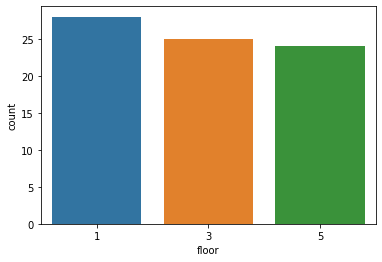

In [32]:
sns.countplot(dataset.floor)

## sample audio

In [37]:
# sample wav for testing purposes
sampled = raw_dataset.sample(1)
SAMPLE_WAV_PATH=os.path.join("/content","Data",sampled.samples.values[0])

In [38]:
metadata = torchaudio.info(SAMPLE_WAV_PATH,format="wav")
print(metadata)

AudioMetaData(sample_rate=48000, num_frames=480000, num_channels=1, bits_per_sample=16, encoding=PCM_S)


In [46]:
waveform,sample_rate = torchaudio.load(SAMPLE_WAV_PATH,format="wav")
print_stats(waveform,sample_rate)

Sample Rate: 48000
Shape: (1, 480000)
Dtype: torch.float32
 - Max:      0.141
 - Min:     -0.131
 - Mean:    -0.000
 - Std Dev:  0.035

tensor([[0.0085, 0.0082, 0.0079,  ..., 0.0464, 0.0482, 0.0495]])



In [47]:
play_audio(waveform,sample_rate)
print("Etage ",sampled.floor.values[0])

Etage  3


In [ ]:
import librosa.display

dat2, sampling_rate2 = librosa.load(os.path.join("/content/Data",sampled.samples.values[0]))
plt.figure(figsize=(20, 10))
D = librosa.amplitude_to_db(np.abs(librosa.stft(dat2)), ref=np.max)
plt.subplot(4, 2, 1)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

In [ ]:
D.shape